In [68]:
import datetime
import os
from uuid import UUID
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from pot.network.node import SelfNodeInfo
from pot.network.storage import BlocksStorage, NodeStorage, TransactionStorage, NodeTrustStorage, ValidatorStorage, \
    TransactionVerifiedStorage
from pot.network.manager import NodeTrust

storage_path = os.path.realpath(os.path.join(os.path.dirname('.'), '..', 'storage'))
result_path = os.path.realpath(os.path.join(os.path.dirname('.'), '..', 'monitor', 'result'))

firsts_records = 500

load_dotenv()

True

In [69]:
def get_self_node_info(path: str) -> UUID:
    old_value = os.getenv('STORAGE_DIR')
    os.environ["STORAGE_DIR"] = path
    self_node = SelfNodeInfo(True)
    os.environ["STORAGE_DIR"] = old_value
    return self_node.identifier


def get_info_from_blockchain(path: str) -> dict:
    storage = BlocksStorage(path)
    blocks = storage.load()
    return {
        "len": len(blocks),
        "transaction_len": sum([len(block.transactions) for block in blocks])
    }


def get_info_from_nodes(path: str) -> dict:
    storage = NodeStorage(path)
    nodes = storage.load()
    trust = NodeTrust.__new__(NodeTrust)
    trust._storage = NodeTrustStorage(path)
    # trust._storage.load()
    # print(f"Trust from {path}: {trust._storage.load()}")
    # old_value = os.getenv('STORAGE_DIR')
    # os.putenv('STORAGE_DIR', path)
    # self_node = SelfNodeInfo()
    # os.putenv('STORAGE_DIR', old_value)
    return {
        "len": len(nodes),
        #"trust": trust.get_node_trust(self_node.get_node())
        "trust": trust._storage.load()
    }


def get_info_from_validators(path: str) -> dict:
    storage = ValidatorStorage(path)
    validators = storage.load()
    return {
        "len": len(validators),
        "validators": ','.join([v.hex for v in validators])
    }


def get_info_from_transactions_to_verify(path: str) -> dict:
    storage = TransactionStorage(path)
    try:
        txs = storage.load()
    except Exception as e:
        print(f"Error while processing path {path}: {e}")
        txs = []
    return {
        "len": len(txs)
    }


def get_info_from_transactions_verified(path: str) -> dict:
    storage = TransactionVerifiedStorage(path)
    txs = storage.load()
    return {
        "len": len(txs)
    }

In [70]:
cols_dict = {
    'time': 'Time',
    'number_of_nodes': 'Number of nodes',
    'number_of_validators': 'Number of validators',
    # 'node_trust': 'Node trust',
    'number_of_blocks': 'Number of blocks',
    'number_of_transaction_to_verify': 'Number of transactions to verify',
    'number_of_verified_transactions': 'Number of verified transactions',
    'validators': 'Validators'
}

cols = list(cols_dict.keys())

df_trust = pd.DataFrame(columns=["time", "sourceNode", "node", "trust"])
df_trust.set_index(["time", "sourceNode", "node"], inplace=True)
# df_trust.sort_index()

In [71]:
first_time = None
dfs = {}

nodes_mapping = {}

for node in os.listdir(storage_path):
    # list all nodes in dir

    if node == '.gitignore':
        continue

    print(f"Processing node {node}")

    trust_data = []

    df = pd.DataFrame(columns=cols)
    df.set_index('time', inplace=True)

    dirs = [int(time_dir) for time_dir in os.listdir(os.path.join(storage_path, node, 'dump'))]
    dirs.sort()
    print(f"Found {len(dirs)} dirs in node {node}")

    record_i = 0
    for time in dirs:
        time_int = int(time)
        #time = float(time) / Dumper.SECOND_PART
        # list all time in dir
        if not first_time:
            first_time = time

        if firsts_records is not None and firsts_records < record_i:
            break

        storage_dir = os.path.join(storage_path, node, 'dump', str(time_int))
        # print(f"Processing dir {storage_dir}")

        if node not in nodes_mapping.keys():
            self_node_id = get_self_node_info(storage_dir)
            nodes_mapping[node] = self_node_id.hex
            print(self_node_id.hex)

        try:
            #self_node_id = get_self_node_info(storage_dir)
            blocks_info = get_info_from_blockchain(storage_dir)
            nodes_info = get_info_from_nodes(storage_dir)
            validators_info = get_info_from_validators(storage_dir)
            txs_to_ver_info = get_info_from_transactions_to_verify(storage_dir)
            txs_ver_info = get_info_from_transactions_verified(storage_dir)
        except Exception as e:
            print(f"Exception {e} while loading from node: {node} from time {time}")
            raise e

        actual_time = time - first_time
        df.loc[actual_time] = [
            nodes_info['len'],
            validators_info['len'],
            # nodes_info["trust"],
            blocks_info['len'],
            txs_to_ver_info['len'],
            txs_ver_info['len'],
            validators_info["validators"]
        ]
        for node_id, trust in nodes_info["trust"].items():
            trust_data.append({
                "time": actual_time,
                "sourceNode": node,
                "node": node_id.hex,
                "trust": trust
            })
            # df_trust.loc[(actual_time, node, node_id.hex), :] = trust
        record_i += 1

    # check if all df has step by step info
    #df.to_excel(os.path.join(result_path, f"result-{node}.xlsx"))
    dfs[node] = df

    df_trust_node = pd.DataFrame(trust_data, columns=["time", "sourceNode", "node", "trust"])
    df_trust_node.set_index(["time", "sourceNode", "node"], inplace=True)
    #df_trust_node.to_excel(os.path.join(result_path, f"result-trust-{node}.xlsx"))

    df_trust = pd.concat([df_trust, df_trust_node])


Processing node 6f7401eea505
Found 12588 dirs in node 6f7401eea505
23086354db2341a7a9fca09b9851a233
Processing node 660309f1771f
Found 12490 dirs in node 660309f1771f
c611f6898988492284deac66c2ce7860
Processing node ac8b100c4294
Found 12844 dirs in node ac8b100c4294
17c07c86163649629282ac7379241c5d
Processing node e331517d2ebd
Found 12645 dirs in node e331517d2ebd
1f3c9c492c8b4da3bb3ea133aa11d083
Processing node effeac7ad947
Found 12747 dirs in node effeac7ad947
9d1812d5c3ce4681902f614bca4b2d4f
Processing node 8f091b7fcfaf
Found 12692 dirs in node 8f091b7fcfaf
3734dbd584e440c4906a499989223cdc
Processing node 99956f462915
Found 12539 dirs in node 99956f462915
89a45d80f7d047b18582eb2152cb5a28


In [73]:
for node, df in dfs.items():
    df.drop(columns=['validators'], inplace=True)

import random

uno = random.choice(list(dfs.values()))
uno = dfs.get(list(dfs.keys())[0])
uno.head()

,number_of_nodes,number_of_validators,number_of_blocks,number_of_transaction_to_verify,number_of_verified_transactions
time,,,,,
0,6,1,1,0,0
1,6,1,1,0,0
2,6,1,1,0,0
3,6,1,1,0,0
4,6,1,1,0,0


In [79]:
import itertools
import random
col = "number_of_verified_transactions"
col = "number_of_nodes"
max_value = 0
data = {}
for node, df in dfs.items():
    data[node] = df[col]
    if max_value < df[col].max():
        max_value = df[col].max()

#random_data = data.get(list(data.keys())[0])
random_data = random.choice(list(data.values()))
pprint(random_data)
random_change = random.choice(random_data)
# random_change = random_data[random.randint(0, len(random_data) - 1)]
print("Change: " + str(int(random_change)))
first_idx = random_data[random_data == random_change].first_valid_index()
print("First index: " + str(int(first_idx)))

df_show = pd.DataFrame(data)

df_show = df_show.loc[first_idx - 5:first_idx + 5]


time
-108    4
-107    4
-106    4
-105    4
-104    4
       ..
 407    7
 408    7
 409    7
 410    7
 411    7
Name: number_of_nodes, Length: 501, dtype: int64
Change: 7
First index: 13


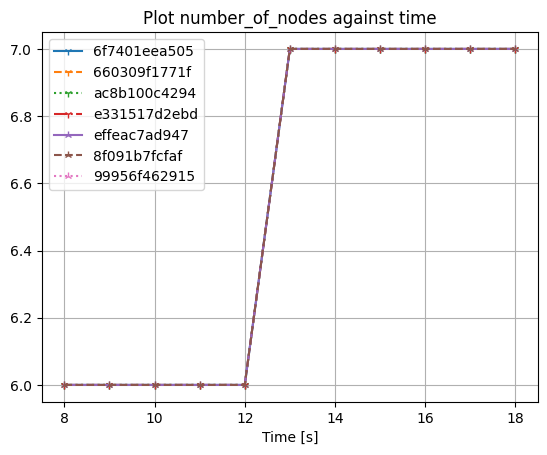

In [75]:
#df_show = pd.DataFrame(data)
markers = ["1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
line_styles = ['-', '--', ':', '-.']
styles = itertools.cycle([marker + line for marker in markers for line in line_styles])
style_list = [next(styles) for _ in df_show.columns]
df_show.plot(
        style=style_list,
        legend=True,
        title=f"Plot {col} against time",
        xlabel="Time [s]",
        #ylim=(max(0, int(-max_value * 0.1)), max_value + max_value * 0.1),
        grid=True
    )
plt.savefig(os.path.join(result_path, f"plot-{col}.png"))

1866

Index 0 for validators 6c0d6727453640048d0ad5a977ac4ac6
Index 19 for validators 1592bdbb409f46d6ad0c1aa8e51b0360,285b9ed67a214329af06e6a9ee5d28b2
Index 175 for validators 6c0d6727453640048d0ad5a977ac4ac6,9b55ff3ca9b540778da0ff576f69cc10
Index 328 for validators 4d5cf72eb0a84162a85c26a5d0051079,b8d9a3b6c6da4e2daa907687cfe4c978
Index 485 for validators ab086f26851a46538805ad83d144fad6,4d5cf72eb0a84162a85c26a5d0051079
